## Redes Neurais Artificiais 2025.1

- **Disciplina**: Redes Neurais Artificiais 2025.1  
- **Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)  
- **Github**: http://github.com/elloa  

|Alunos                |Matrícula  |
|----------------------|-----------|
|Caio Bertoldo         |2215080050 |
|Danilo Jorge          |2215080007 |
|Diogo Gomes           |2215080033 |
|Guilherme Montenegro  |2215080011 |
|Leonardo Abinader     |2215080042 |
|Rodolfo Simões        |2215080073 |

## Busca em Grade
A grade de busca (em inglês, Grid Search) é um método de otimização de hiperparâmetros amplamente utilizado em Aprendizado de Máquina. Ela busca encontrar a melhor combinação de parâmetros para um modelo, de modo a melhorar seu desempenho (por exemplo, acurácia, F1-score, etc.).

Em Aprendizado de Máquina, hiperparâmetros são configurações que influenciam o treinamento do modelo, mas não são aprendidos pelos dados.

A ideia é:

1. Definir um conjunto de valores possíveis para cada hiperparâmetro;

2. Criar uma grade (combinação cartesiana) com todas as combinações possíveis desses valores;

3. Avaliar o desempenho de cada combinação usando validação cruzada;

4. Escolher a combinação com melhor resultado.

In [14]:
# Bibliotecas
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from joblib import Parallel, delayed, dump
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Carregar o dataset
df = pd.read_csv('datasets/updated_pollution_dataset_scaled.csv')

# Separar as variáveis independentes (X) e a variável dependente (y)
X = df.drop(columns=['Air Quality Encoded'])
y = df['Air Quality Encoded']

### Propondo arquiteturas

Para escolha do número de neurônios para os Multi-Layer Perceptron (MLP) foi utilizado a _Regra da Pirâmide Geométrica_, que é uma heurística empírica usada para estimar o número de neurônios nas camadas ocultas de uma Rede Neural Artificial (RNA). Ela sugere uma estrutura de rede em forma de pirâmide, onde o número de neurônios diminui progressivamente da entrada para a saída. Essa regra segue a fórmula:

$$N_{h} = \alpha \cdot \lceil \sqrt{ N_{i} \cdot N_{o}}\rfloor$$

Em que $N_h$, $N_i$ e $N_o$ representam o número de neurônios nas camadas ocultas (a serem distribuídos em 1 ou 2 camadas), entrada e saída, respectivamente. O operador $\lceil \cdot \rfloor$ representa o inteiro mais próximo.

Os valores de $\alpha$ foram escolhidos arbitrariamente.

In [5]:
# Regra da Pirâmide Geométrica
alpha = [0.5, 1, 1.5, 2]

n = round((X.shape[1] * len(y.unique()))**0.5)
nh = [int(n * a) for a in alpha]
nh

[3, 6, 9, 12]

Assim será proposto 4 MLPs de camada única e mais 12 MLPs com duas camadas com os neurônios distribuidos entre elas.

Como função de ativação, foram escolhidas as funções ReLU e Tangente Hiperbólica com os _solvers_ Adam e SGD. Além disso, todas as MLPs serão treinadas com 300 épocas.

No fim, serão escolhidas as 3 melhores configurações de modelo nos dois métodos de validação a seguir, totalizando até 6 configurações

### Busca em Grade com Validação Hold-out

O método Hold-Out consiste em dividir o conjunto total de dados em dois subconjuntos mutuamente exclusivos, um para treinamento (estimação dos parâmetros) e outro para teste (validação). O conjunto de dados pode ser separado em quantidades iguais ou não. Uma proporção muito comum é considerar 80% (ou 70%) dos dados para treinamento e os 20% (ou 30%) restantes para teste.

Nessa validação foi escolhida a separação de conjuntos 70/30.

In [9]:
# Arquiteturas e hiperparâmetros
architectures = [(3,), (2, 1), 
                (6,), (4, 2), (5, 1),
                (9,), (5, 4), (6, 3), (7, 2), (8, 1),
                (12,), (7, 5), (8, 4), (9, 3), (10, 2), (11, 1)]

functions = ['relu', 'tanh']

solvers = ['adam', 'sgd']

epochs = [300]

grid_holdout = list(product(architectures, functions, solvers, epochs))

In [10]:
# Função para treinar e avaliar o modelo
def treino_e_avaliacao(X, y, grid):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    mlp = MLPClassifier(
        hidden_layer_sizes = grid[0],
        activation = grid[1],
        solver = grid[2],
        max_iter = grid[3],
        verbose = False
    )

    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    return acc, prec, rec, f1, cm, y_test, y_pred, mlp

In [20]:
# Função para pegar as 3 melhores redes
def get_top3(overall_averages, grid):
    top3 = sorted(overall_averages, key = lambda av: (av[1], av[0]), reverse = True)[:3]

    print("\nTop-3 modelos por Acurácia e F1-score (médias):\n")

    for i, (f1, acc, prec, rec, idx, _, _, _, _) in enumerate(top3):
        print(f"Top {i + 1}: Arquitetura {idx}: Modelo = {grid[idx]}")
        print(f"Acurácia = {100*acc:.2f}% | Precisão: {100*prec:.2f}% | Revocação: {100*rec:.2f}% | F1-score =  {100*f1:.2f}% |\n")

    return top3

In [15]:
# Diretório onde os modelos serão salvos
os.makedirs("mlp_modelos_holdout", exist_ok = True)

# Resultados detalhados para análise posterior
media_geral_arquiteturas = []
resultados_detalhados = []


for idx, model in enumerate(grid_holdout):
    print(f"Executando modelo {idx + 1}/{len(grid_holdout)}: {model}")

    resultados = Parallel(n_jobs = -1)(delayed(treino_e_avaliacao)(X, y, model) for _ in range(100))

    acuracias = [r[0] for r in resultados]
    precsisoes = [r[1] for r in resultados]
    revocacoes = [r[2] for r in resultados]
    f1_scores = [r[3] for r in resultados]

    # Melhor execução com base em F1 (desempate por acurácia)
    melhor_resultado = max(resultados, key = lambda r: (r[3], r[0]))
    acc, prec, rec, f1, cm, y_test, y_pred, mlp_model = melhor_resultado

    # Salvar o melhor modelo no disco
    nome_arquivo = f"mlp_modelos_holdout/modelo_{idx:02d}_acc{acc:.4f}_f1{f1:.4f}.joblib"
    dump(mlp_model, nome_arquivo)

    media_acc = np.mean(acuracias)
    media_prec = np.mean(precsisoes)
    media_rec = np.mean(revocacoes)
    media_f1 = np.mean(f1_scores)
    desvio_acc = np.std(acuracias)
    desvio_prec = np.std(precsisoes)
    desvio_rev = np.std(revocacoes)
    desvio_f1 = np.std(f1_scores)

    # Armazenar resultados
    media_geral_arquiteturas.append((media_f1, media_acc, media_prec, media_rec, idx, desvio_f1, desvio_acc, desvio_prec, desvio_rev))
    resultados_detalhados.append({
        'modelo': model,
        'acuracia': acc,
        'precisao': prec,
        'revocacao': rec,
        'f1_score': f1,
        'cm': cm,
        'y_test': y_test,
        'y_pred': y_pred
    })

Executando modelo 1/64: ((3,), 'relu', 'adam', 300)
Executando modelo 2/64: ((3,), 'relu', 'sgd', 300)
Executando modelo 3/64: ((3,), 'tanh', 'adam', 300)
Executando modelo 4/64: ((3,), 'tanh', 'sgd', 300)
Executando modelo 5/64: ((2, 1), 'relu', 'adam', 300)
Executando modelo 6/64: ((2, 1), 'relu', 'sgd', 300)
Executando modelo 7/64: ((2, 1), 'tanh', 'adam', 300)
Executando modelo 8/64: ((2, 1), 'tanh', 'sgd', 300)
Executando modelo 9/64: ((6,), 'relu', 'adam', 300)
Executando modelo 10/64: ((6,), 'relu', 'sgd', 300)
Executando modelo 11/64: ((6,), 'tanh', 'adam', 300)
Executando modelo 12/64: ((6,), 'tanh', 'sgd', 300)
Executando modelo 13/64: ((4, 2), 'relu', 'adam', 300)
Executando modelo 14/64: ((4, 2), 'relu', 'sgd', 300)
Executando modelo 15/64: ((4, 2), 'tanh', 'adam', 300)
Executando modelo 16/64: ((4, 2), 'tanh', 'sgd', 300)
Executando modelo 17/64: ((5, 1), 'relu', 'adam', 300)
Executando modelo 18/64: ((5, 1), 'relu', 'sgd', 300)
Executando modelo 19/64: ((5, 1), 'tanh', 'a


Top-3 modelos por Acurácia e F1-score (médias):

Top 1: Arquitetura 50: Modelo = ((8, 4), 'tanh', 'adam', 300)
Acurácia = 94.45% | Precisão: 92.24% | Revocação: 91.45% | F1-score =  91.80% |

Top 2: Arquitetura 46: Modelo = ((7, 5), 'tanh', 'adam', 300)
Acurácia = 94.39% | Precisão: 92.13% | Revocação: 91.34% | F1-score =  91.70% |

Top 3: Arquitetura 48: Modelo = ((8, 4), 'relu', 'adam', 300)
Acurácia = 94.32% | Precisão: 92.03% | Revocação: 91.25% | F1-score =  91.60% |


Top 1 - Modelo: ((8, 4), 'tanh', 'adam', 300)
Acurácia: 95.67%
Precisão: 94.65%
Revocação: 93.39%
F1-Score: 93.94%


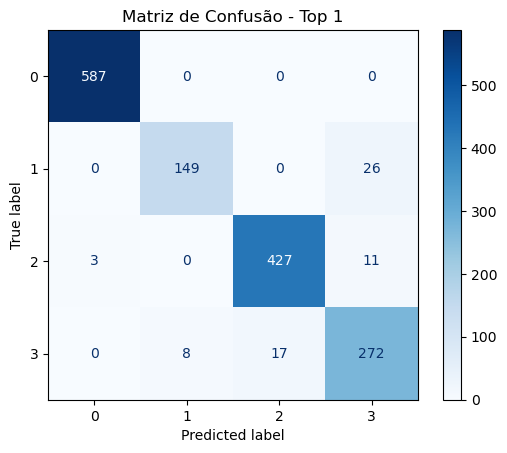


Top 2 - Modelo: ((7, 5), 'tanh', 'adam', 300)
Acurácia: 95.47%
Precisão: 94.22%
Revocação: 94.09%
F1-Score: 94.15%


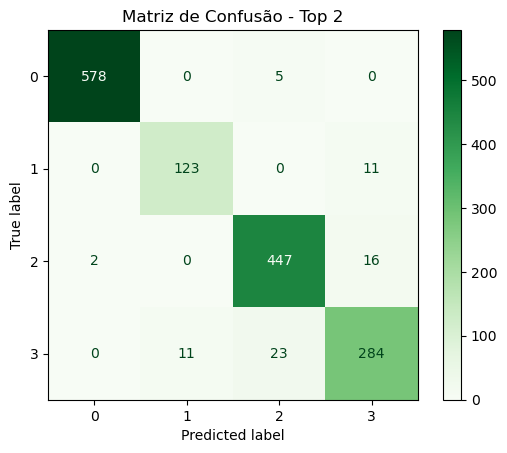


Top 3 - Modelo: ((8, 4), 'relu', 'adam', 300)
Acurácia: 96.00%
Precisão: 93.56%
Revocação: 93.39%
F1-Score: 93.47%


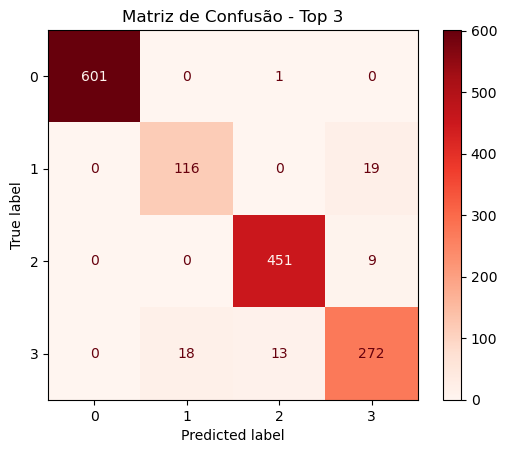

In [22]:
# Mostra top-3 com matrizes
top3_resultados = get_top3(media_geral_arquiteturas, grid_holdout)

# Exibir matrizes de confusão para as 3 melhores
cmaps = ['Blues', 'Greens', 'Reds']

for i, (_, _, _, _, idx, _, _, _, _) in enumerate(top3_resultados):
    melhor = resultados_detalhados[idx]
    print(f"\nTop {i + 1} - Modelo: {melhor['modelo']}")
    print(f"Acurácia: {100*melhor['acuracia']:.2f}%")
    print(f"Precisão: {100*melhor['precisao']:.2f}%")
    print(f"Revocação: {100*melhor['revocacao']:.2f}%")
    print(f"F1-Score: {100*melhor['f1_score']:.2f}%")
    disp = ConfusionMatrixDisplay.from_predictions(melhor['y_test'], melhor['y_pred'], cmap = cmaps[i])
    disp.ax_.set_title(f'Matriz de Confusão - Top {i + 1}')
    plt.show()

### Busca em Grade com Validação Cruzada (K-Fold)

O método de validação cruzada denominado k-fold consiste em dividir o conjunto total de dados em k subconjuntos mutuamente exclusivos do mesmo tamanho e, a partir daí, um subconjunto é utilizado para teste e os k-1 restantes são utilizados para estimação dos parâmetros, fazendo-se o cálculo da acurácia do modelo. Este processo é realizado k vezes alternando de forma circular o subconjunto de teste.

Como conjunto de dados não é grande e na tentativa de buscar um melhor desempenho, foi escolhido 10 folds.

In [17]:
# Grid de parâmetros
param_grid = {
    'hidden_layer_sizes': [(3,), (2, 1), 
                        (6,), (4, 2), (5, 1),
                        (9,), (5, 4), (6, 3), (7, 2), (8, 1),
                        (12,), (7, 5), (8, 4), (9, 3), (10, 2), (11, 1)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'max_iter': [300]
}

In [43]:
# Busca em Grade com 10-Fold
grid_cv = GridSearchCV(MLPClassifier(), 
                       param_grid, 
                       cv = 5,
                       scoring = 'f1_macro',
                       n_jobs = -1,
                       verbose = 2)

In [44]:
grid_cv.fit(X, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [(3,), (2, 1), (6,), (4, 2),
                                                (5, 1), (9,), (5, 4), (6, 3),
                                                (7, 2), (8, 1), (12,), (7, 5),
                                                (8, 4), (9, 3), (10, 2),
                                                (11, 1)],
                         'max_iter': [300], 'solver': ['adam', 'sgd']},
             scoring='f1_macro', verbose=2)

In [45]:
results = pd.DataFrame(grid_cv.cv_results_)
results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.106388,0.477751,0.008078,0.001893,relu,"(3,)",300,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.887667,0.922439,0.909785,0.910795,0.916603,0.909458,0.011801,22
1,2.358315,0.358934,0.007192,0.000952,relu,"(3,)",300,sgd,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.866131,0.924122,0.884140,0.637277,0.896700,0.841674,0.103928,39
2,2.390758,1.352408,0.006340,0.001446,relu,"(2, 1)",300,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.668525,0.924921,0.901955,0.142857,0.142857,0.556223,0.349234,59
3,3.240069,0.595443,0.006818,0.001468,relu,"(2, 1)",300,sgd,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.888862,0.887900,0.412568,0.658112,0.662271,0.701943,0.177060,50
4,2.526674,0.518127,0.006239,0.001806,relu,"(6,)",300,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.890239,0.926995,0.911152,0.911540,0.923070,0.912599,0.012807,20


In [59]:
# Pegando os top 3
top3_idx = np.argsort(results['rank_test_score'])[:3]
top3_cv = results.loc[top3_idx].reset_index(drop=True)
top3_cv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.383997,0.828549,0.006190,0.000683,tanh,"(8, 4)",300,adam,"{'activation': 'tanh', 'hidden_layer_sizes': (...",0.905749,0.927345,0.920524,0.917363,0.930035,0.920203,0.008541,1
1,3.355780,0.602747,0.007454,0.002461,relu,"(7, 2)",300,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.894862,0.919864,0.930171,0.917771,0.933572,0.919248,0.013578,2
2,3.778076,0.713943,0.006694,0.001005,relu,"(5, 4)",300,adam,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.891836,0.934386,0.918263,0.917432,0.929408,0.918265,0.014719,3


In [58]:
# Resultados dos melhor solução
best_solution_idx = grid_cv.best_index_
print("Parâmetros:")
print("Função de Ativação: " + results['param_activation'][best_solution_idx])
print("Número de neurônios ocultos por camada: " + str(results['param_hidden_layer_sizes'][best_solution_idx]))

print("\nHiperparâmetros:")
print("Solver: " + results['param_solver'][best_solution_idx])
print("Épocas: " + str(results['param_max_iter'][best_solution_idx]))

print("\nResultados por fold:")
for i in range(5):
    fold_score = results[f'split{i}_test_score'][best_solution_idx]
    print(f"Fold {i+1}: {fold_score:.4f}")

print(f"\nF1-score médio (validação cruzada): {results['mean_test_score'][best_solution_idx]:.4f}")
print(f"Desvio padrão: {results['std_test_score'][best_solution_idx]:.4f}")


Parâmetros:
Função de Ativação: tanh
Número de neurônios ocultos por camada: (8, 4)

Hiperparâmetros:
Solver: adam
Épocas: 300

Resultados por fold:
Fold 1: 0.9057
Fold 2: 0.9273
Fold 3: 0.9205
Fold 4: 0.9174
Fold 5: 0.9300

F1-score médio (validação cruzada): 0.9202
Desvio padrão: 0.0085


In [60]:
for idx in top3_cv.index:
    melhor = top3_cv.loc[idx]
    print(f"\nTop {idx + 1} - Modelo: {melhor['param_hidden_layer_sizes']}")
    print(f"Função de Ativação: {melhor['param_activation']}")
    print(f"Acurácia: {100*melhor['mean_test_score']:.2f}%")
    print(f"Precisão: {100*melhor['mean_test_score']:.2f}%")
    print(f"Revocação: {100*melhor['mean_test_score']:.2f}%")
    print(f"F1-Score: {100*melhor['mean_test_score']:.2f}%")


Top 1 - Modelo: (8, 4)
Função de Ativação: tanh
Acurácia: 92.02%
Precisão: 92.02%
Revocação: 92.02%
F1-Score: 92.02%

Top 2 - Modelo: (7, 2)
Função de Ativação: relu
Acurácia: 91.92%
Precisão: 91.92%
Revocação: 91.92%
F1-Score: 91.92%

Top 3 - Modelo: (5, 4)
Função de Ativação: relu
Acurácia: 91.83%
Precisão: 91.83%
Revocação: 91.83%
F1-Score: 91.83%
